In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
searched_format = 'csv'
for file in os.listdir(os.getcwd()):
    if searched_format in file:
        PATH = os.path.abspath(file)

In [9]:
cycle_rent_df = pd.read_csv(PATH, parse_dates=['timestamp'])
cycle_rent_df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


## Убедимся, что всё считалось правильно: посмотрим на столбцы, типы данных, размерность, наличие пропущенных значений.

In [10]:
cycle_rent_df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [11]:
cycle_rent_df.shape

(17414, 10)

In [12]:
cycle_rent_df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [13]:
cycle_rent_df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [14]:
cycle_rent_df.nunique()

timestamp       17414
cnt              3781
t1                 73
t2                 82
hum               143
wind_speed        103
weather_code        7
is_holiday          2
is_weekend          2
season              4
dtype: int64

## Посмотрим на число поездок по датам и времени. Построим график.

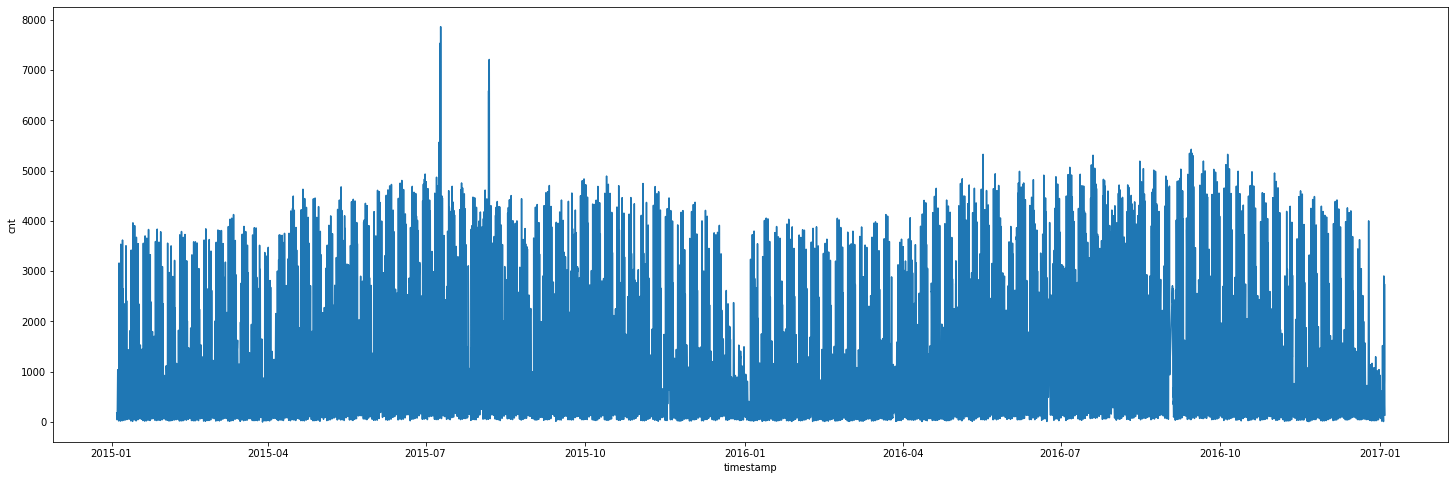

In [35]:
# по оси x – дата (timestamp)
# по оси y – число поездок (cnt)

plt.figure(figsize = (25,8))
sns.lineplot(data=cycle_rent_df, x='timestamp', y='cnt')
 

## Преобразуем данные столбца timestamp ко дню и саггрегируем данные по числу поездок по дню.

In [129]:
agged_df = cycle_rent_df.sort_values('timestamp', ascending=False) \
                        .set_index('timestamp') \
                        .resample(rule='D') \
                        .agg({'cnt': 'sum'}) \
                        
agged_df

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601
...,...
2016-12-30,11566
2016-12-31,11424
2017-01-01,6421


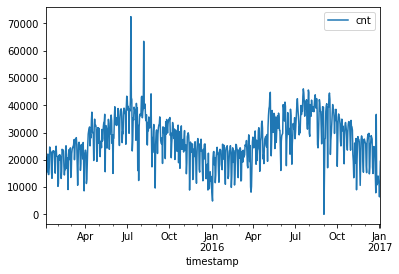

In [51]:
agged_df.plot()

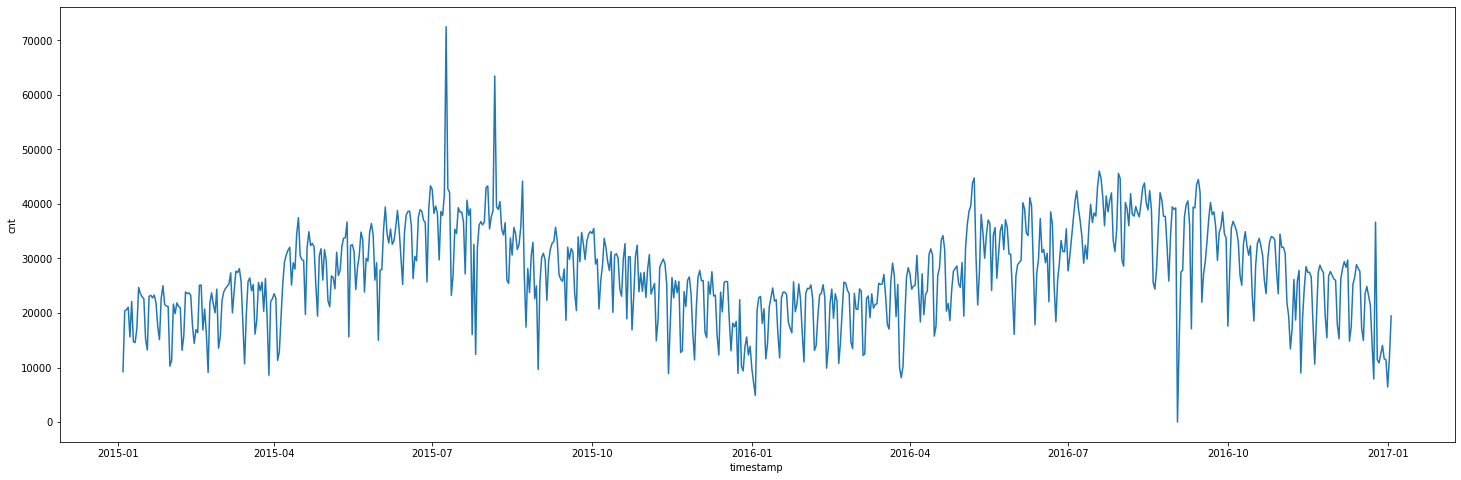

In [41]:
plt.figure(figsize = (25,8))
sns.lineplot(data=agged_df, x='timestamp', y='cnt')

## Проанализируем, что произошло в тех временных интервалах, где наблюдаются аномальные скачки в данных.

### Этап I: посчитаем скользящее среднее с окном 3

In [155]:
agged_rolling_mean_df = agged_df.rolling(3).mean().reset_index()
agged_rolling_mean_df

,timestamp,cnt
0,2015-01-04,NaN
1,2015-01-05,NaN
2,2015-01-06,16739.666667
3,2015-01-07,20683.000000
4,2015-01-08,19092.666667
...,...,...
726,2016-12-30,12682.000000
727,2016-12-31,12347.333333
728,2017-01-01,9803.666667
729,2017-01-02,9889.333333


In [156]:
int(agged_rolling_mean_df.query('timestamp == "2015-07-09"').cnt.sum())

50705

### Этап II: посчитаем разницу между наблюдаемыми и сглаженными значениями и определим стандартное отклонение полученной разницы

In [157]:
reseted_agged_df = agged_df.reset_index()
reseted_agged_df.head()

,timestamp,cnt
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601


In [158]:
agged_rolling_mean_df = agged_rolling_mean_df.assign(cnt_difference = reseted_agged_df.cnt.astype('float64') - agged_rolling_mean_df.cnt).rename(columns={'cnt': 'cnt_mean'}) 

In [159]:
agged_rolling_mean_df.head()

,timestamp,cnt_mean,cnt_difference
0,2015-01-04,NaN,NaN
1,2015-01-05,NaN,NaN
2,2015-01-06,16739.666667,3873.333333
3,2015-01-07,20683.000000,381.000000
4,2015-01-08,19092.666667,-3491.666667


In [160]:
# Стандартное отклонение
cnt_sd = np.std(agged_rolling_mean_df.cnt_difference)
cnt_sd

4558.58664111794

### Этап III: определим границы 99% доверительного интервала:

In [161]:
agged_rolling_mean_df = agged_rolling_mean_df \
                                            .assign(
                                                    upper_bound = agged_rolling_mean_df.cnt_mean + 2.576 * cnt_sd, 
                                                    lower_bound = agged_rolling_mean_df.cnt_mean - 2.576 * cnt_sd
                                                    )

In [162]:
agged_rolling_mean_df

,timestamp,cnt_mean,cnt_difference,upper_bound,lower_bound
0,2015-01-04,NaN,NaN,NaN,NaN
1,2015-01-05,NaN,NaN,NaN,NaN
2,2015-01-06,16739.666667,3873.333333,28482.585854,4996.747479
3,2015-01-07,20683.000000,381.000000,32425.919188,8940.080812
4,2015-01-08,19092.666667,-3491.666667,30835.585854,7349.747479
...,...,...,...,...,...
726,2016-12-30,12682.000000,-1116.000000,24424.919188,939.080812
727,2016-12-31,12347.333333,-923.333333,24090.252521,604.414146
728,2017-01-01,9803.666667,-3382.666667,21546.585854,-1939.252521
729,2017-01-02,9889.333333,1933.666667,21632.252521,-1853.585854


In [163]:
last_upper_bound = round(agged_rolling_mean_df.tail(1).upper_bound, 2).sum()
last_upper_bound

24302.92

### Этап IV: изучим аномально высокие значения! Выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.

##### Вариант без добавления столбца реальных значений в agged_rolling_mean_df

In [170]:
comparing_cnt = agged_df.reset_index().cnt.astype('float64')
agged_rolling_mean_df.query("@comparing_cnt > upper_bound").sort_values('cnt_mean', ascending=False)

,timestamp,cnt_mean,cnt_difference,upper_bound,lower_bound
186,2015-07-09,50705.000000,21799.000000,62447.919188,38962.080812
214,2015-08-06,46627.333333,16840.666667,58370.252521,34884.414146
721,2016-12-25,19650.666667,17002.333333,31393.585854,7907.747479
609,2016-09-04,14259.000000,13253.000000,26001.919188,2516.080812


In [165]:
agged_rolling_mean_df.query("@comparing_cnt > upper_bound").sort_values('cnt_mean', ascending=False).head(1).timestamp

186   2015-07-09
Name: timestamp, dtype: datetime64[ns]

##### Вариант с добавлением столбца реальных значений в agged_rolling_mean_df

In [167]:
agged_rolling_mean_total_df = agged_rolling_mean_df.copy()
agged_rolling_mean_total_df['real_cnt'] = agged_df.reset_index().cnt.astype('float64')

In [168]:
agged_rolling_mean_total_df

,timestamp,cnt_mean,cnt_difference,upper_bound,lower_bound,real_cnt
0,2015-01-04,NaN,NaN,NaN,NaN,9234.0
1,2015-01-05,NaN,NaN,NaN,NaN,20372.0
2,2015-01-06,16739.666667,3873.333333,28482.585854,4996.747479,20613.0
3,2015-01-07,20683.000000,381.000000,32425.919188,8940.080812,21064.0
4,2015-01-08,19092.666667,-3491.666667,30835.585854,7349.747479,15601.0
...,...,...,...,...,...,...
726,2016-12-30,12682.000000,-1116.000000,24424.919188,939.080812,11566.0
727,2016-12-31,12347.333333,-923.333333,24090.252521,604.414146,11424.0
728,2017-01-01,9803.666667,-3382.666667,21546.585854,-1939.252521,6421.0
729,2017-01-02,9889.333333,1933.666667,21632.252521,-1853.585854,11823.0


In [171]:
agged_rolling_mean_total_df.query("real_cnt > upper_bound").sort_values('real_cnt', ascending=False)

,timestamp,cnt_mean,cnt_difference,upper_bound,lower_bound,real_cnt
186,2015-07-09,50705.000000,21799.000000,62447.919188,38962.080812,72504.0
214,2015-08-06,46627.333333,16840.666667,58370.252521,34884.414146,63468.0
721,2016-12-25,19650.666667,17002.333333,31393.585854,7907.747479,36653.0
609,2016-09-04,14259.000000,13253.000000,26001.919188,2516.080812,27512.0


In [ ]:
agged_rolling_mean_total_df.query("real_cnt > upper_bound").sort_values('real_cnt', ascending=False).head(1).timestamp

### Этап V: изучим аномально низкие значения! Выведем наблюдения, для которых наблюдаемые значения оказались меньше нижней границы 99% доверительного интервала.

In [175]:
agged_rolling_mean_total_df.query("real_cnt < lower_bound").sort_values('real_cnt')

,timestamp,cnt_mean,cnt_difference,upper_bound,lower_bound,real_cnt
607,2016-09-02,26086.333333,-26086.333333,37829.252521,14343.414146,0.0
314,2015-11-14,21037.333333,-12139.333333,32780.252521,9294.414146,8898.0
678,2016-11-12,20878.000000,-11888.000000,32620.919188,9135.080812,8990.0
130,2015-05-14,28709.333333,-13100.333333,40452.252521,16966.414146,15609.0
201,2015-07-24,31013.666667,-14979.666667,42756.585854,19270.747479,16034.0
615,2016-09-10,31262.000000,-14182.000000,43004.919188,19519.080812,17080.0
232,2015-08-24,29529.333333,-12129.333333,41272.252521,17786.414146,17400.0
621,2016-09-16,36193.333333,-14226.333333,47936.252521,24450.414146,21967.0
189,2015-07-12,36036.666667,-12796.666667,47779.585854,24293.747479,23240.0


In [177]:
agged_rolling_mean_total_df.query("real_cnt < lower_bound").sort_values('real_cnt').head(1).timestamp

607   2016-09-02
Name: timestamp, dtype: datetime64[ns]